# Milestone 3 - Media coverage of violent events in war zone

In the current era of mass communication, globalization, on-demand video, social medias and instant messaging, media and newspapers (increasingly digital) have a central position.

Nowadays, news instantly travel the globe, and they travel *massively*.

The 2000s have been a time of war, but mostly war located far from 'developed' countries, many important conflicts happened such as Iraq's war, Syria's war, the Arab Spring, September 11th or Mali's war. Many of these conflicts involved NOTA's countries or Russia, these countries are often at war but by long distance. 

This Modern media coverage of these conflicts is at the center of many ethical discussions. The recurrent critisism is that newspapers focus their article topics arbitrarily and often have a debatable sense of priority.

If such a claim were true, the consequences could be significant given the importance of modern medias in inhabitants of western countries daily lives. A lack of coverage of a conflict by newspapers could make people think that the situation in countries at war improved when it has not.

## 1. Hypothesis and Data retrieval

### **Our hypothesis is that there exists a loss of interest of medias over time for some countries even when this country is still at war and that this coverage is biased towards western countries' views and in particular the U.S.A.**

To achieve this we chose to use the [**GDELT 2.0 dataset**](https://www.gdeltproject.org/). 

We chose to analyse the media coverage of violent events in some specific countries (Afghanistan, Syria, Iraq, Pakistan and Mexico) over the years 2000 to 2016.

Among the data provided in the dataset we used :

* *ActionGeo_CountryName*, the 2-character FIPS10-4 country code for the location of the events to get the countries.
* [*EventRootCode*](http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf) 18, 19 and 20 that correspond to the most violent events in the documentation.
* *MonthYear* to have the date (in month and year) of each event
* *Events* that we got from our SQL query as being the number of events per month
* *Articles* from our SQL query as well, being the number of Articles per month

We also chose to extract data from the [**UCDP**](http://ucdp.uu.se/) dataset, we kept only our featured countries and the best estimation given for the number of deaths per year.

## 2. Imports, global names and helper functions

In [29]:
import pandas as pd
import pyarrow.parquet as pq
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sbs
import numpy as np
from plots_helpers import *


In [30]:
total_articles_file = 'Articles_year.csv'
total_events_file = 'totevent_code181920.csv'
ucdp_file = 'ged171.csv'
gdelt_file = 'big_query_2000_2016.csv'
top_events_file = 'top_event_2000_2016.csv'
top_articles_file = 'top_acticles_2000_2016.csv'
years = [2000, 2016]

In [31]:
def read_csv(filename, years=years, year_col='Year'):
    x = pd.read_csv(filename)
    x = x[(x[year_col] >= years[0]) & (x[year_col] <= years[1])]
    return x

In [32]:
def deaths_country(_df, country_name):
    x = _df[_df['Country'] == country_name].drop('Country', axis=1).groupby('Date').sum().reset_index()
    if(country_name == 'Mexico'):
        # We need to artificially add some rows for mexico due to missing (no deaths) data these years
        x = x.append(pd.DataFrame([[2003, 0], [2000, 0], [2001, 0]], columns=['Date', 'Deaths'])).sort_values('Date')
    x['Deaths'] = x['Deaths']
    return x.set_index('Date')

In [33]:
def df_country(_df, country):
    return _df[_df.Country == country].drop('Country', axis=1).set_index(['Date'])

In [34]:
# Plot a barplot of the number od death per year, over the ratio number of article per event per year.
def plot_tendency(country_name,deaths, ratio):
    #global parameters
    fig_height = 12
    fig_weight = 12
    date = np.arange(2000,2017,1,dtype=np.int64) # stop value excluded
    year_xlabel = r"year of study"
    left_axis = r"ratio article/event"
    right_axis = r"number of deaths"    
    
    tendency_title = r"Media Coverage Tendency Over The Number Of Death in "+country_name
    f,ax_ = plt.subplots(sharex=True)
    f.set_figheight(fig_height)
    f.set_figwidth(fig_weight)
    plt.title(tendency_title)
    plt.xlabel(year_xlabel)
    
    ax_.set_xticks(date)
    ax_right = ax_.twinx()

    ax_.bar(date,deaths)
    ax_right.plot(date,ratio,color='r' )

    plt.show()

## 3. Data Collection and Description

## 3.1 Processing of the UCDP dataset

### 3.1.1 DataFrame creations

*articles_year* and *events_year* represent the number of articles (resp. events) per year in the world.

In [35]:
articles_year = read_csv(total_articles_file)
articles_year = articles_year.rename(columns={"NbArticles_Year": "NumArticles"})
events_year = read_csv(total_events_file)

events_year.head()

,Year,NumEvents
21,2000,330047
22,2001,390659
23,2002,344684
24,2003,403647
25,2004,401826


*deaths* represent the number of deaths by country per year

In [36]:
deaths = read_csv(ucdp_file, year_col='year')
deaths = deaths[['year', 'country', 'best']]
deaths.columns = ['Date', 'Country', 'Deaths']

deaths.head()

,Date,Country,Deaths
0,2010,Yemen (North Yemen),2
1,2011,Yemen (North Yemen),0
2,2011,Yemen (North Yemen),0
3,2012,Yemen (North Yemen),5
4,2012,Yemen (North Yemen),5


### 3.1.2 Country separation

Here we create one dataframe per country

In [37]:
deaths_irq = deaths_country(deaths, 'Iraq')
deaths_afg = deaths_country(deaths, 'Afghanistan')
deaths_mex = deaths_country(deaths, 'Mexico')
deaths_pak = deaths_country(deaths, 'Pakistan')

deaths_irq.head()

,Deaths
Date,
2000,185
2001,27
2002,111
2003,7999
2004,4365


## 3.2 Processing of our aggregation of the GDELT dataset

We first tried to get the data from the cluseter but the dataset present on it was a subset of GDELT. Therefore most of the features were missing. To get the location of an event we used at first "Source" and "Target" field that matched the country we were intrested in. But those entries were not consistent.
The full dataset was supposed to have an ActionGeo_Country code which represent the county were the event took place. We were also supposed to have access to features like "MonthYear", "EventRootCode",...

For all those reasons we decided to stop using the cluster and make our query on the full GDELT dataset using the [Google Big Query](https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events)

The sql queries can be found on the repository

### 3.2.1 DataFrame creation

*df* represents our aggregated gdelt data(sub)set

In [38]:
df = pd.read_csv(gdelt_file)
df.columns = ['Country', 'Date', 'EventCode', 'Events', 'Articles']

df.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,26118,558078
1,SY,201608,19,23797,513882
2,SY,201602,19,27567,483618
3,SY,201510,19,27216,469990
4,SY,201612,19,22474,468685


### 3.2.2 Normalization

This part is important. To be able to correctly analyse our data, we need to normalize the number of articles (resp. events) per year in the aggregated gdelt dataset by the total number of articles (resp. events) in the world this year.

This normalization is required, and we discuss in part **3.4** of why it is.

In [39]:
tmp = pd.DataFrame(df['Date'].apply(lambda x: int(x / 100))).rename(columns={'Date': 'Year'})
tmp[['Articles', 'Events']] = df[['Articles', 'Events']]
tmp = tmp.merge(articles_year, how='left').merge(events_year, how='left')
tmp['Articles'] = (tmp['Articles'] / tmp['NumArticles'])
tmp['Events'] = (tmp['Events'] / tmp['NumEvents'])
df_normalized = df.copy()
df_normalized[['Articles', 'Events']] = tmp[['Articles', 'Events']]

tmp.drop(['NumEvents', 'NumArticles', 'Year'], axis=1).head()

,Articles,Events
0,0.005663,0.004158
1,0.005215,0.003789
2,0.004907,0.004389
3,0.005244,0.004753
4,0.004756,0.003578


The data that we get out of our query is the number of Event and the number of Articles aggregated per country, MonthYear and EventCode.
Aggregating the data this way enables us to work on a consise dataset (compared to the original enormous GDELT). However we still keep the different event code and month data separated for further analysis.

In [40]:
df_normalized.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,0.004158,0.005663
1,SY,201608,19,0.003789,0.005215
2,SY,201602,19,0.004389,0.004907
3,SY,201510,19,0.004753,0.005244
4,SY,201612,19,0.003578,0.004756


## 3.3 Separation by country and aggregation per year and event code

In this part, we will create new dataframes that will hold our data aggregated by country and date, while forgetting (for now) the event types.

We will also create a new column, called *Ratio*, that will represent the ratio (in a given country and year) of the number of articles over the number of events (both normalized).

In [41]:
df_grouped = df_normalized.groupby(['Date', 'Country']).sum().drop(['EventCode'], axis=1).sort_index(level=[0,1])

df_merged = df_grouped.reset_index()

irq = df_country(df_merged, 'IZ')
mex = df_country(df_merged, 'MX')
pak = df_country(df_merged, 'PK')
afg = df_country(df_merged, 'AF')
syr = df_country(df_merged, 'SY')

df_merged.head()

,Date,Country,Events,Articles
0,200001,AF,0.000600,0.000571
1,200001,IZ,0.000824,0.000874
2,200001,MX,0.000300,0.000250
3,200001,PK,0.002715,0.003148
4,200001,SY,0.000561,0.000456


Creation of the ratio column.

In [42]:
df_year = df_merged.copy()

df_year['Date'] = df_year['Date'].apply(lambda d: int(d/100))

df_year = df_year.groupby(['Date', 'Country']).sum().reset_index()

df_year['Ratio'] = df_year['Articles'] / df_year['Events'].astype('float')

irq_year1 = df_country(df_year, 'IZ')
mex_year1 = df_country(df_year, 'MX')
pak_year1 = df_country(df_year, 'PK')
afg_year1 = df_country(df_year, 'AF')
syr_year1 = df_country(df_year, 'SY')

df_year.head()

,Date,Country,Events,Articles,Ratio
0,2000,AF,0.012501,0.012148,0.971773
1,2000,IZ,0.011335,0.011045,0.974412
2,2000,MX,0.005454,0.005516,1.011380
3,2000,PK,0.024351,0.027095,1.112696
4,2000,SY,0.004221,0.003140,0.744014


Merging of both dataset informations.

In [43]:
irq_year = deaths_irq.join(irq_year1)
mex_year = deaths_mex.join(mex_year1)
pak_year = deaths_pak.join(pak_year1)
afg_year = deaths_afg.join(afg_year1)

irq_year.head()

,Deaths,Events,Articles,Ratio
Date,,,,
2000,185,0.011335,0.011045,0.974412
2001,27,0.012615,0.012875,1.020623
2002,111,0.020169,0.021691,1.075432
2003,7999,0.118185,0.137051,1.159632
2004,4365,0.160283,0.176554,1.101513


## 3.4 Data inconsistencies and points to be careful of

In this section, we'll detail some issues and important points to keep in minds regarding the data. 

During the processing stage, we found several such issues that we needed to address to make the reader aware of the potential problems is this study.

### 3.4.1 UCDP dataset problems

Merging datasets coming from different sources must always be done carefuly. The UCDP dataset has proved useful, allowing us to add information on casualities by year in different countries. However, we noted several problems.

First, some parts of the data are suspicously missing. For instance in the U.S. only 3 events in the 2000-2016 time frame (including the world trade center terrosist attack) are recorded, even though numerous mass shooting happen every year in this country.

We also found that Syria data is completely blank, which prevented us to do an analysis of Syria similar to the other countries. However we will still use the Syrian data when comparing countries on their global media coverage since we felt that this conflict had a big place in the news those last years. 

Overall, the data seem quite inconsistent, Mexico casualities for example are at 0 in 2000, 2001 and 2003 but we don't know if that's really the case or if the data is simply missing.

### 3.4.2 Increase of data quantity over time and scale issues

During the retrieval of the GDELT dataset, we noted that the quantity of articles and events (and data in general), increases drastically over the years. We suspect that is due to the project's increasing maturity, the improvement in data retrieval techniques, and the huge increase in news sources (e.g. via internet).

Below you can find the table that show the number of articles and events over the years and the corresponding barplot.

In [44]:
articles_events_year = articles_year.merge(events_year).set_index('Year')

articles_events_year

,NumArticles,NumEvents
Year,,
2000,1610092,330047
2001,1919419,390659
2002,1560261,344684
2003,2080567,403647
2004,1970998,401826
2005,1402859,290738
2006,2032533,575386
2007,5103387,1044619
2008,7196901,1259645


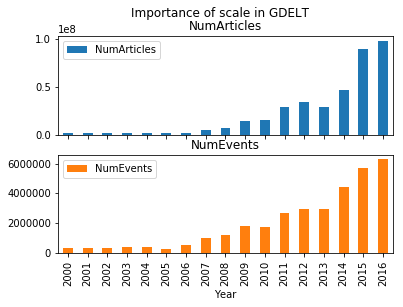

In [45]:
articles_events_year.plot(kind='bar', subplots=True,
                                    title='Importance of scale in GDELT')
plt.show()

In [46]:
articles_events_2000_2016 = articles_events_year.drop([x for x in range(2001, 2016)])

diff = pd.DataFrame(articles_events_2000_2016.loc[2016] / articles_events_2000_2016.loc[2000])

diff

,0
NumArticles,61.206576
NumEvents,19.031392


As you can see, the difference of scale can be huge, almost a factor of 61 (resp.20) for articles (resp. events) between 2000 and 2016.

### 3.4.3 Scale differences between countries

The countries we chose to study (namely Afghanistan, Iraq, Mexico, Pakistan and Syria) face very different conflicts. 

Mexico for example, is mostly subject to gang wars while Iraq inhabitants had to deal with war with the U.S.

This creates huge scale differences between countries, the most obvious one being the casualities. We need to keep this in mind in our study.

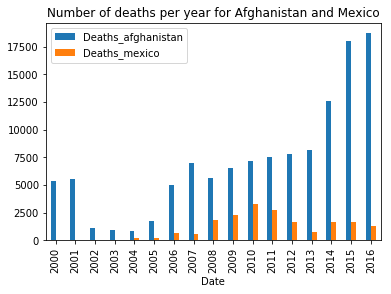

In [47]:
deaths_afg.merge(deaths_mex, how='outer', left_index=True, right_index=True)\
    .rename(columns={'Deaths_x': 'Deaths_afghanistan','Deaths_y': 'Deaths_mexico'})\
    .plot(kind='bar', title='Number of deaths per year for Afghanistan and Mexico')
plt.show()

As we can see on the plot above, taking the example of Afghanistan and Mexico, the difference of scale in casualities is quite important.

### 3.4.4 GDELT inconsistency in event codes

We found another surprising problem in the GDELT dataset, it seems that the coverage of very serious events (e.g. mass shootings) is inconsistent in the data.

The event code 20, supposed to be the worst events, have a surprisingly low articles/events ratio.


EventRootCode:
18: ASSAULT 
19: FIGHT
20: USE UNCONVENTIONAL MASS VIOLENCE


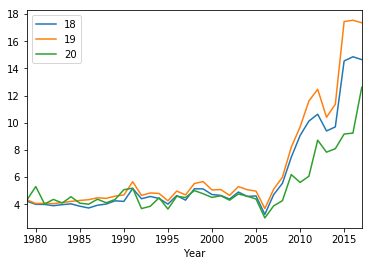

Loading BokehJS ...

In [48]:
ecc = pd.read_csv('EventCode_coverage.csv')
ecc = ecc[ecc["EventRootCode"].isin(["18","19", "20"])]
years = np.ndarray.tolist(np.arange(2000,2017,1))
years_dict = dict()
for y in years:
    art = ecc[ecc.Year== y]
    years_dict["_"+str(y)] = art
    y_str = "_"+str(y)
fig, ax = plt.subplots()
labels = []
for key, grp in ecc.groupby(['EventRootCode']):
    ax = grp.plot(ax=ax, kind='line', x='Year', y='Articles_per_Event')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
layout = year_slider_plot("The number of Articles per Violent Event per Year", years_dict,
                          FactorRange(*years_dict[y_str]['EventRootCode']),
                          DataRange1d(start=0.0, end=20),
                          "EventRootCode", "Articles_per_Event",
                          2, 10)
print("\nEventRootCode:\n18: ASSAULT \n19: FIGHT\n20: USE UNCONVENTIONAL MASS VIOLENCE")
plt.show()
output_notebook()
show(layout)

### 3.4.5 Bias in the number of articles depending on countries

Lastly, we want to bring the reader's attention towards the articles bias we found in GDELT. It seems that the number of articles by country is highly biased towards the U.S.A. Our hypothesis is that most article sources actually come from the U.S., hence the important coverage of U.S. and neighbouring countries (e.g. Mexico).

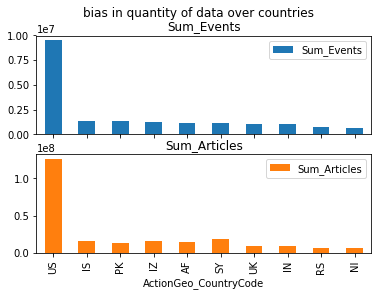

In [49]:
te = pd.read_csv(top_events_file).sort_values('Sum_Events', ascending=False)
ta = pd.read_csv(top_articles_file).sort_values('Sum_Articles', ascending=False)

te.merge(ta).set_index("ActionGeo_CountryCode").head(10).plot(kind='bar', subplots=True, 
                                        title='bias in quantity of data over countries')
plt.show()
(art,map_i) = world_map_data_processing("Articles_year_country.csv","Articles_year.csv")
world_map_visu(art,map_i)


As we can see on the plots above of the 10 countries with the most data, the difference of scale is very high but most importantly, it is only high between the U.S. and other countries, hence our hypothesis.

## 4. Results and Findings

In this section we will confront the results extacted from the datasets against our hypothesis. 

## 4.1 Relations Between Events and Articles

The first thing we would like to ensure is that the number of articles and the number of events are highly correlated. This is a reasonable expectation because logically, the more violent events, the more articles.

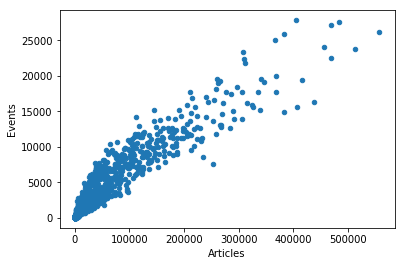

Correlation between Events and Articles: 0.945


In [50]:
df.plot(kind='scatter', x='Articles', y='Events')
plt.show()
print("Correlation between Events and Articles: %0.3f" %df.corr().loc["Events", "Articles"])

As we can see the correlation is indeed very high. We will use the number of articles for an event as a measure of importance for this event. The fact that those two measures are correlated allows us to confidently use them together. <br>
Therefore our use of the ratio between articles and events, in further results, is a reasonable unit of measure of coverage.

## 4.2 Global visualization of parameters

The next visualization showcases the whole data we are using concisely.<br>
An horizontal analysis gives us a sense of scale between countries and a vertical analysis shows the different behaviors and tendencies of our parameters for each country.

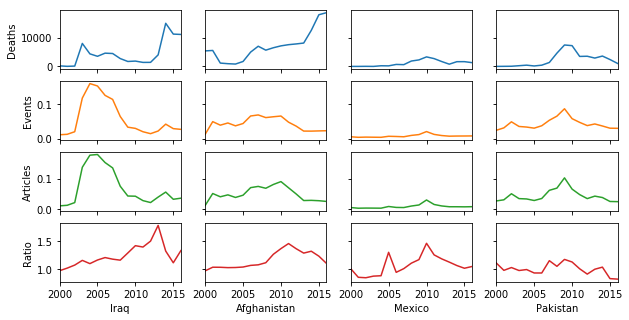

In [51]:
f, mosaic = plt.subplots(4, 4, figsize=(10, 5), sharex=True, sharey='row')

for i, c in enumerate([irq_year, afg_year, mex_year, pak_year]):
    c.plot(ax=mosaic[:, i], subplots=True, legend=False)
    
mosaic[0, 0].set_ylabel('Deaths')
mosaic[1, 0].set_ylabel('Events')
mosaic[2, 0].set_ylabel('Articles')
mosaic[3, 0].set_ylabel('Ratio')
mosaic[3, 0].set_xlabel('Iraq')
mosaic[3, 1].set_xlabel('Afghanistan')
mosaic[3, 2].set_xlabel('Mexico')
mosaic[3, 3].set_xlabel('Pakistan')

plt.show()

Starting by the analysis between countries, we can see that, in terms of scale, Mexico and Pakistan are significantly smaller regarding casualties.
One should also observe the difference between Iraq and Afghanistan regarding the number of events and articles. Recalling that the war is Iraq started in 2003 and the war in Afghnistan started in 2001 we could expect a similar treatment for both countries.


Now regarding the vertical analysis, one can notice that the correlation between the number of deaths and the number of articles (or events) for each country can be very different. We illustrate this difference in the table below. 

In [52]:
correlations = {}
for i, x in enumerate([(irq_year, 'Iraq'), (afg_year, 'Afghanistan'), (mex_year, 'Mexico'), (pak_year, 'Pakistan')]):
        correlations[x[1]] = x[0].corr().loc['Deaths', 'Articles']
pd.DataFrame.from_dict(correlations, orient='index').rename(columns = {0: "correlation"})

,correlation
Iraq,0.155456
Afghanistan,-0.271881
Mexico,0.865304
Pakistan,0.752315


We can see that Mexico and Pakistan have very high correlations while Iraq and Afghanistan have very low ones. This is very interesting, and shows a glimpse of the validity of our initial hypothesis.<br>
Mexico has is general a smaller number of deaths compared to other countries we considered. Therfore the number of identified violent event and the number of articles concerning those events is smaller. However the coverage of thos events is consistant and proportional over time. The same behavior can be observed for Pakistan. i.e around 2009 the number of deaths had a peak, the number of identified event had also a peak as well as the articles. Now taking advantage of this mosaic plot to compare behavior between countries we can see that this proportional coverage of the number of deaths is not true for Iraq and Afghanistan. Even leading to a negative correlation between articles and deaths for Afghanistan... Basically the number of deaths increase, the number of articles decrease.<br>
We will discuss this coverage per country more in depth in the following section.<br>
Finally we can also visualize the correlation exposed before between the number of identified events ans the number of articles per identidied violent event. It holds for all countries.

## 4.3 Analysis by country per year

The next discussion is an analysis per country per year. The aim of the following plot is to see how the (normalized) ratio between the events and the articles evolves against the deaths.
The normalized ratio is the normalized number of articles divided by the normalized number of events. (See **3.2.2**)
We supposed that for events that lead to a lot of deaths, the number of articles should be grater for this event. Therefore a increasing ratio for period with a lot of deaths in a country would indicate a good coverage.

However we are looking for lost of interest. Therefore, if the lost of interest is generalized over all the scrapped sources of the GDELT data, the number of identified event would decrease also and the ratio would be a biased unit of measure. We have assumed that a violent event is at least mentionned by one of the sources. <br>
We were able to make some interesting qualitative analysis with this measures as written below.

In [53]:
tab_irq = country_tab('Iraq', irq_year['Deaths'], irq_year['Ratio'])
tab_afg = country_tab('Afghanistan', afg_year['Deaths'], afg_year['Ratio'])
tab_mex = country_tab('Mexico', mex_year['Deaths'], mex_year['Ratio'])
tab_pak = country_tab('Pakistan', pak_year['Deaths'], pak_year['Ratio'])
tabs = Tabs(tabs=[ tab_irq, tab_afg, tab_mex, tab_pak ])
output_notebook()
show(tabs)

Loading BokehJS ...

We will do one analysis per country since the goal of this plot is not to compare country directly to each other since the scale of deaths is not fixed.

- Iraq:<br>
    The first important point is that in 2003 it is the beginning of the war. Ragarding the ratio we can see an increasing in the number of articles per event. Until 2008 it looks like the ratio is proportional. However after that the ratio increase but not the number of death. A possible explaination is that the US combat force started withdraw in 2009. It is logical that such an event is picked up by the press. Between 2011 and 2013 we see a big increase in the ratio. This period correspond to the "Arab Spring". Given that the articles talking about Iraq's border countries has exploded the media naturally covered events in Iraq as well. In 2015 the ratio drastically dropped while the number of deaths remains very high. Events in Iraq may have been "drowned" by other events e.g French terrorist attacks, Syria situations...
<br>
- Afghanistan:<br>
    Afghanistan's data seem to be logical from 2000 to around 2011, i.e. the ratio follows more or less the number of deaths (while being slightly higher between 2002 and 2005). However from 2011, the ratio dropped dramatically whereas the number of deaths increased a lot. This may be explained in part by the beginning of war in Syria for example but the difference between the ratio and deaths is too high to only be explained by this. It seems that the interest of media for Afghanistan dropped when it shouldn't have.
<br>
- Mexico:<br>
    The case of Mexico is different, most of armed conflicts in this country come from cartel wars and not international wars. The ratio of articles over events seem to follow quite logically the number of deaths.
<br>
- Pakistan:<br>
    Pakistan coverage by media seems to be quite good until 2011. After, the ratio drops significantly. Once again this can be due to the increase of events in the rest of the world, but it looks like it might be a case of loss of interest as well.
    
    
Overall, it seems like the coverage of media really isn't very fair since the ratio between the number of articles and number of events doesn't follow the curve of number of deaths at some points.


## 4.4 Articles distributions for violent events

The analysis of the evolution of the ratio was a good mesures to see how well the media reacts to events identified. However another useful information is the distribution of the number of articles per year in the coutries of interest.<br>
Below are two visualizations of this infomation one is the analysis per year isolating the countries of interest the other is a world map with the entire distribution.

In [54]:
article_ratio_per_country = df_year[["Date", "Country", "Articles"]]

In [55]:
sum_article_world = pd.read_csv("Articles_year.csv")
#Filter from 2000-20016
sum_article_world = sum_article_world[(sum_article_world.Year >1999)]
sum_article_world = sum_article_world[(sum_article_world.Year <2017)]
sum_article_world=sum_article_world.rename_axis({"Year":"Date", "NbArticles_Year":"NbArticles"}, axis=1)
sum_article_world

years = np.ndarray.tolist(np.arange(2000,2017,1))
years_dict = dict()
for y in years:
    art = article_ratio_per_country[article_ratio_per_country.Date== y]
    years_dict["_"+str(y)] = art
    y_str = "_"+str(y)
layout = year_slider_plot("The Proportion Of Articles Per Year and Per Country", years_dict,
                          FactorRange(*years_dict[y_str]['Country']),
                          DataRange1d(start=0.0, end=0.2),
                          "Country", "Articles",
                          3.5, 0.15)
output_notebook()
show(layout)

Loading BokehJS ...

This plot shows a relatively normal behavior. The articles about Iraq represented between 2003 and 2007 around 15% of all articles treating violent event in the world. In terms of proportion other countries were small compared to it. One should noticed that Afghanistan never had more than 10% of articles even if, except for years 2002 to 2005, it has the highest number of deaths.<br>
In 2010 Mexico reaches his peak, that year in this country, 3000 people were killed close to the U.S frontier and a peak for Pakistan was reached in 2009 were the country suffered from more than 6000 deaths from state based violence.
 

 
In 2012, the Syrian war began and we can see the ratio of it growing significanlty. However, in 2014, the ratio of Iraq and Syria are close, even if the number of deaths is around seven times higher in Syria. We could ask ourself why is that? For us it is just an example of countries not being covered in the same way in american's press.

From year 2013 we can observe also that the proportions in generals are lower for each highlighted countries. Therefore we thought it would be a good idea, in order to have a wider view, to see wich other countries were treated at those moments, that lead to those lower proportion.

The interactive map below offers this wider view. We deliberately remove the measurement of the U.S in order to see the proportion in the other countries, since the U.S is an outlier in our case.


In [56]:
(art,map_i) = world_map_data_processing("Articles_year_181920.csv","Articles_181920.csv")
map_i.remove('USA')
world_map_visu(art,map_i)

One can find suprising the high color value in Russia in the early 2000's. This correspond to the Chechen-Russian conflit. This appart, this map is used to analyse the reason why the Syrian conflit hasn't as big as expected in the last years (i.e Iraq in 2005). As we can see from 2011, the media attention was distributed in the countries where the arab spring took place. The Syrian war is a consequence of it, but the interest of the situation is Syria in not proporional to the syrian deaths. We ponctuate this analyse by exposing a know but "unfair" behavior. In 2015 France has suffered from terrorist attacks that lead to around 130 deaths. The attention given to that single event was almost the same than the one given to Iraq or Syria for all the events of the year. The scarcity of this event and the fact that France is a developped country played a huge role in the amoungt of articles. Is each death equal?

## 5. Conclusion

From our study, it seems that our hypothesis is founded and that newspapers lose interest over time for some countries at war even if it is still raging. The wars in Iraq and Afghanistan in particular seem to showcase the most this effect. This may be due to the fact that the U.S. were involved in these wars. The coverage for Mexico and Pakistan looks to be a bit more reasonable. 

However we cannot state that our conclusion is definitely true since there are too many parameters to take into account such as location bias, unknown reliability of GDELT and UCDP datasets or scale difference over the years, even if our data processing got rid of part of the biases. We can still reasonably state that our hypothesis is probably true.

This loss of interest is really important to note so that it can be worked on. Medias can't just choose the most sensational war and only talk about it. Iraqi prime minister announced the end Iraq Civil War against ISIS less than a month ago. Have you heard of it?
People die every day all around the world but if we don't even hear about it, we might think everything's going fine besides some particular wars.